## Comparing pyclesperanto and OPM deskewing results

Pyclesperanto deskewing shows artefacts due to composing a single affine transformation for shearing and rotation. Comparing this to the OPM implementation by Doug Shepherd. 

It appears that the OPM code doesn't have artefacts as it processes plane by plane and performs interpolation between them.

In [1]:
from numba import njit, prange
import numpy as np
import napari 
import pyclesperanto_prototype as cle
from skimage.io import imread


img = imread("../sample_data/RBC_lattice.tif")

voxel_size_x_in_microns = 0.1449922
voxel_size_y_in_microns = 0.1449922
voxel_size_z_in_microns = 0.3

deskewing_angle_in_degrees = 30

print("Shape of original image", img.shape )

#Perform deskewing on rbc image  
deskewed_cle = cle.deskew_y(img, 
                        angle_in_degrees=deskewing_angle_in_degrees, 
                        voxel_size_x=voxel_size_x_in_microns, 
                        voxel_size_y=voxel_size_y_in_microns, 
                        voxel_size_z=voxel_size_z_in_microns)

print("Shape of pyclesperanto deskewed image",deskewed_cle.shape)

Shape of original image (150, 118, 209)
Shape of pyclesperanto deskewed image (59, 413, 209)


In [2]:
#OPM_DESKEW
#https://github.com/QI2lab/OPM/blob/5dc5a4f2046d220e09d038ae6d292f3590e4f015/reconstruction/image_post_processing.py#L33

@njit(parallel=True)
def opm_deskew(data,theta,distance,pixel_size):
    """
    Perform parallelized orthogonal interpolation into a uniform pixel size grid.
    
    :param data: ndarray
        image stack of uniformly spaced OPM planes
    :param theta: float 
        angle relative to coverslip
    :param distance: float 
        step between image planes along coverslip
    :param pizel_size: float 
        in-plane camera pixel size in OPM coordinates
    :return output: ndarray
        image stack of deskewed OPM planes on uniform grid
    """

    # unwrap parameters 
    [num_images,ny,nx]=data.shape     # (pixels)

    # change step size from physical space (nm) to camera space (pixels)
    pixel_step = distance/pixel_size    # (pixels)

    # calculate the number of pixels scanned during stage scan 
    scan_end = num_images * pixel_step  # (pixels)

    # calculate properties for final image
    final_ny = np.int64(np.ceil(scan_end+ny*np.cos(theta*np.pi/180))) # (pixels)
    final_nz = np.int64(np.ceil(ny*np.sin(theta*np.pi/180)))          # (pixels)
    final_nx = np.int64(nx)                                           # (pixels)

    # create final image
    output = np.zeros((final_nz, final_ny, final_nx),dtype=np.float32)  # (time, pixels,pixels,pixels - data is float32)

    # precalculate trig functions for scan angle
    tantheta = np.float32(np.tan(theta * np.pi/180)) # (float32)
    sintheta = np.float32(np.sin(theta * np.pi/180)) # (float32)
    costheta = np.float32(np.cos(theta * np.pi/180)) # (float32)

    # perform orthogonal interpolation

    # loop through output z planes
    # defined as parallel loop in numba
    # http://numba.pydata.org/numba-doc/latest/user/parallel.html#numba-parallel
    for z in prange(0,final_nz):
        # calculate range of output y pixels to populate
        y_range_min=np.minimum(0,np.int64(np.floor(np.float32(z)/tantheta)))
        y_range_max=np.maximum(final_ny,np.int64(np.ceil(scan_end+np.float32(z)/tantheta+1)))

        # loop through final y pixels
        # defined as parallel loop in numba
        # http://numba.pydata.org/numba-doc/latest/user/parallel.html#numba-parallel
        for y in prange(y_range_min,y_range_max):

            # find the virtual tilted plane that intersects the interpolated plane 
            virtual_plane = y - z/tantheta

            # find raw data planes that surround the virtual plane
            plane_before = np.int64(np.floor(virtual_plane/pixel_step))
            plane_after = np.int64(plane_before+1)

            # continue if raw data planes are within the data range
            if ((plane_before>=0) and (plane_after<num_images)):
                
                # find distance of a point on the  interpolated plane to plane_before and plane_after
                l_before = virtual_plane - plane_before * pixel_step
                l_after = pixel_step - l_before
                
                # determine location of a point along the interpolated plane
                za = z/sintheta
                virtual_pos_before = za + l_before*costheta
                virtual_pos_after = za - l_after*costheta

                # determine nearest data points to interpoloated point in raw data
                pos_before = np.int64(np.floor(virtual_pos_before))
                pos_after = np.int64(np.floor(virtual_pos_after))

                # continue if within data bounds
                if ((pos_before>=0) and (pos_after >= 0) and (pos_before<ny-1) and (pos_after<ny-1)):
                    
                    # determine points surrounding interpolated point on the virtual plane 
                    dz_before = virtual_pos_before - pos_before
                    dz_after = virtual_pos_after - pos_after

                    # compute final image plane using orthogonal interpolation
                    output[z,y,:] = (l_before * dz_after * data[plane_after,pos_after+1,:] +
                                    l_before * (1-dz_after) * data[plane_after,pos_after,:] +
                                    l_after * dz_before * data[plane_before,pos_before+1,:] +
                                    l_after * (1-dz_before) * data[plane_before,pos_before,:]) /pixel_step


    # return output
    return output

deskewed_opm = opm_deskew(img,30.0,0.3,0.1449922)
deskewed_opm = np.flip(deskewed_opm,axis=0) #coverslip rotation
print("Shape of OPM deskewed image",deskewed_opm.shape)

Shape of OPM deskewed image (59, 413, 209)


In [3]:
viewer = napari.Viewer() 
viewer.add_image(img)
viewer.add_image(deskewed_cle)
viewer.add_image(deskewed_opm)

c:\Users\deepu\Anaconda3\envs\napari_lattice\lib\site-packages\napari_tools_menu\__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Image layer 'deskewed_opm' at 0x1c2c74febe0>

c:\Users\deepu\Anaconda3\envs\napari_lattice\lib\site-packages\napari\layers\image\image.py:839: RuntimeWarning: divide by zero encountered in true_divide
  raw_zoom_factor = np.divide(
c:\Users\deepu\Anaconda3\envs\napari_lattice\lib\site-packages\napari\layers\image\image.py:847: RuntimeWarning: divide by zero encountered in true_divide
  zoom_factor = tuple(new_shape / image.shape[:2])


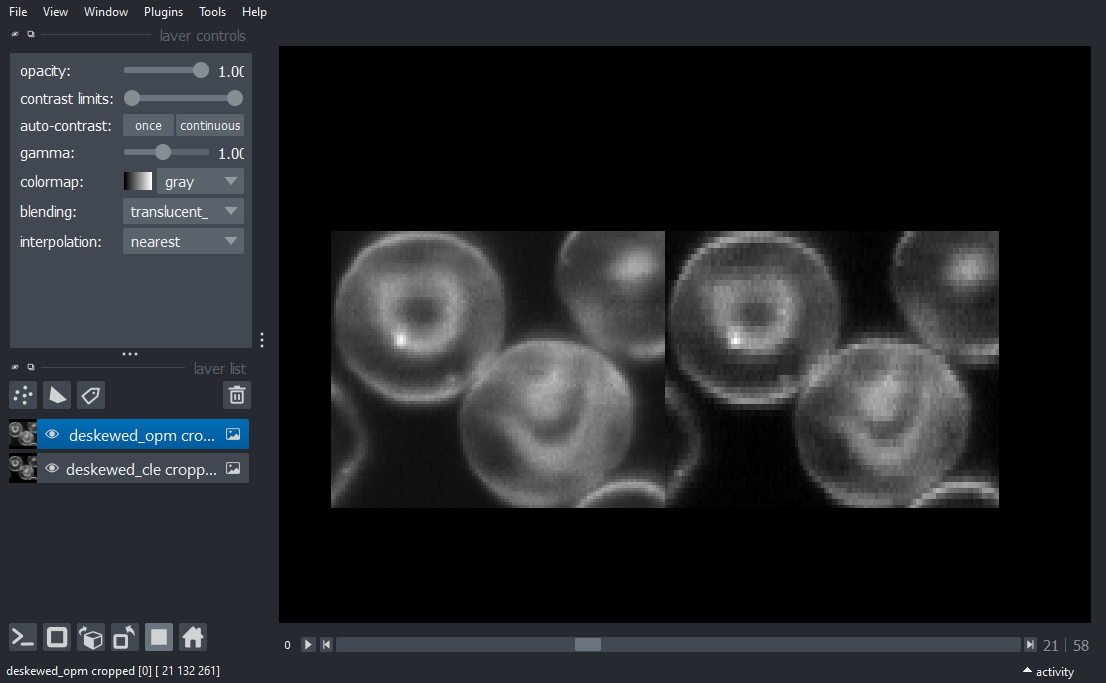

In [5]:
from napari.utils import nbscreenshot
nbscreenshot(viewer)

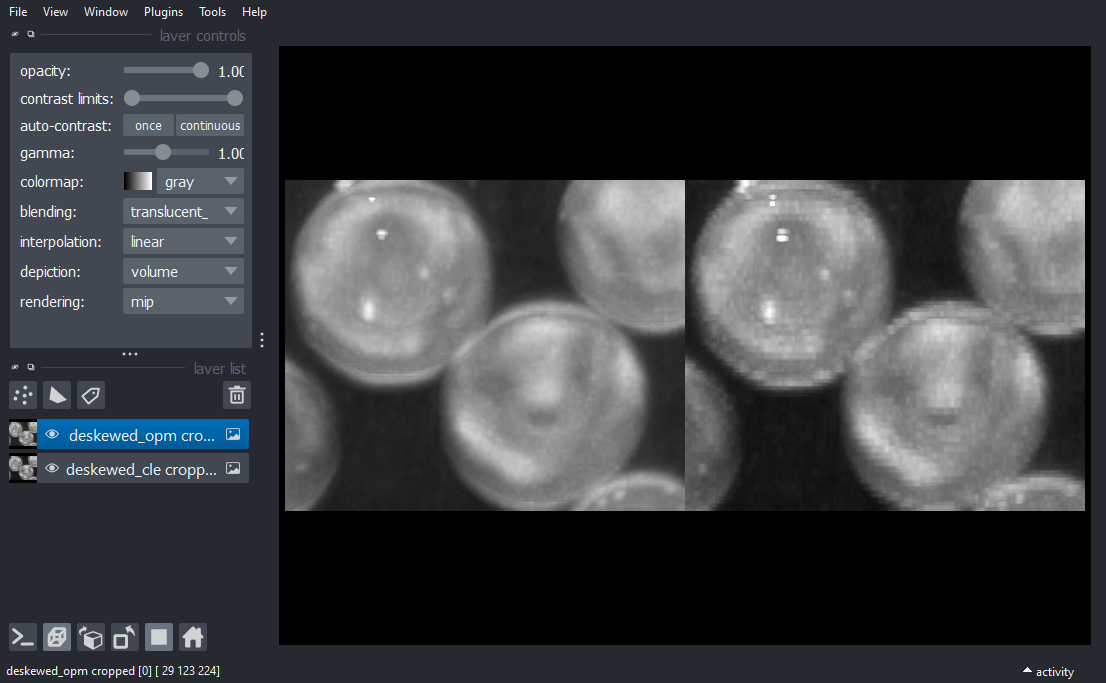

In [6]:
#3D
nbscreenshot(viewer)